## Here we will be loading the wind experiment and then recalculate correlatins
## EASTERLIES

### Good examples to follow
#### - https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/example_notebook.ipynb
#### - https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/figures/Figure-8.ipynb


In [50]:
import cmocean.cm as cmocean
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

#to use the catalog
import intake

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

from dask.distributed import Client

figdir = '/g/data/jk72/ns3783'

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/32831/status,
Dashboard: /proxy/32831/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40601,Workers: 7
Dashboard: /proxy/32831/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:40511,Total threads: 4
Dashboard: /proxy/41003/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:43085,


#### These lines below used to work, but now they do not. Keeping it for reference.

### Try to access data through creating my own database in accordance with this tutorial: https://github.com/adele-morrison/cosima-recipes/blob/master/Tutorials/Make_Your_Own_Database.ipynb

In [51]:
pwd

'/home/581/ns3783'

In [52]:
db = 'local_cc_test.db'
session = cc.database.create_session(db)

In [53]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,01deg_jra55v13_ryf9091_easterlies_up10_zonal,378
1,01deg_jra55v13_ryf9091_easterlies_up10,540
2,01deg_jra55_ryf_Control,384


In [54]:
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'

### PREPARE TEMPERATURE

In [75]:
# plot anomalies for last 5 years of simulation:
start_time='2150-01-01'   #try with 2150 again?
end_time='2159-12-31'

depth_slice = slice(400, 6000)
#lat_slice  = slice(-79,-59)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp_up = cc.querying.getvar(experiment_eup,'temp',session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_upY = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                      
temp_upY = temp_upY.load()

temp_up = cc.querying.getvar(easterlies_up_zonal,'temp',session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_upX = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                           
temp_upX = temp_upX.load()

In [76]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [77]:
temp_con = cc.querying.getvar(control,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                             
temp_con = temp_con.load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 757, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 1016, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22367337494336 and this is thread id 22360803497728.
Exception closing connection <sqlite3.Connection object at 0x145675903e40>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-pa

In [78]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(control,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_con = (temp_con*thickness).sum('st_ocean')/thickness.sum('st_ocean')
temp_upX = (temp_upX*thickness).sum('st_ocean')/thickness.sum('st_ocean')
temp_upY = (temp_upY*thickness).sum('st_ocean')/thickness.sum('st_ocean')

2024-11-17 21:54:43,162 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 14.30 GiB -- Worker memory limit: 17.88 GiB
2024-11-17 21:54:43,210 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 14.30 GiB -- Worker memory limit: 17.88 GiB
2024-11-17 21:54:43,309 - distributed.worker_memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 14.32 GiB -- Worker memory limit: 17.88 GiB
2024-11-17 21:54:43,310 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memo

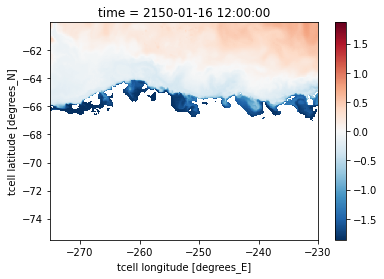

In [79]:
##test if temp is still working after the depth weighting
temp_upY[0,...].plot()
#temp_upY.plot()

In [80]:
temp_con = temp_con.mean('time')
temp_upX = temp_upX.mean('time')
temp_upY = temp_upY.mean('time')

In [81]:
temp_con = temp_con.load()
temp_upX = temp_upX.load()
temp_upY = temp_upY.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


### LOAD ISOPYCNALS 

In [21]:
# load temperature data at 200m (defined on transect):
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-256, -246)

temp_iso = cc.querying.getvar(control,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso = temp_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso = temp_iso.load()

temp_iso_upX = cc.querying.getvar(easterlies_up_zonal,'temp',session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso_upX = temp_iso_upX.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso_upX = temp_iso_upX.load()

temp_iso_upY = cc.querying.getvar(experiment_eup,'temp',session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso_upY = temp_iso_upY.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso_upY = temp_iso_upY.load()

sal_iso = cc.querying.getvar(control,'salt', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso = sal_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso = sal_iso.load()

sal_iso_upX = cc.querying.getvar(easterlies_up_zonal,'salt',session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso_upX = sal_iso_upX.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso_upX = sal_iso_upX.load()

sal_iso_upY = cc.querying.getvar(experiment_eup,'salt',session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso_upY = sal_iso_upY.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso_upY = sal_iso_upY.load()

In [22]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

# calculate density along transect:
# arrays for gsw to use
depth_array_upX = temp_iso_upX*0 + temp_iso_upX.st_ocean
lat_array_upX = temp_iso_upX*0 + temp_iso_upX.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure_upX = gsw.p_from_z(-depth_array_upX,lat_array_upX)
# need to convert practical salinity to absolute salinity:
salt_abs_upX = gsw.SA_from_SP(sal_iso_upX,pressure_upX,sal_iso_upX.xt_ocean,lat_array_upX)
#calculate sigma
sigma0_upX = gsw.sigma0(salt_abs_upX,temp_iso_upX)


# calculate density along transect:
# arrays for gsw to use
depth_array_upY = temp_iso_upY*0 + temp_iso_upY.st_ocean
lat_array_upY = temp_iso_upY*0 + temp_iso_upY.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure_upY = gsw.p_from_z(-depth_array_upY,lat_array_upY)
# need to convert practical salinity to absolute salinity:
salt_abs_upY = gsw.SA_from_SP(sal_iso_upY,pressure_upY,sal_iso_upY.xt_ocean,lat_array_upY)
#calculate sigma
sigma0_upY = gsw.sigma0(salt_abs_upY,temp_iso_upY)


## We need to mask the shelf out 

In [23]:
# cut the data BOX 1
lon_slice  = slice(-255, -246)
lat_slice  = slice(-67.5, -63)

# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

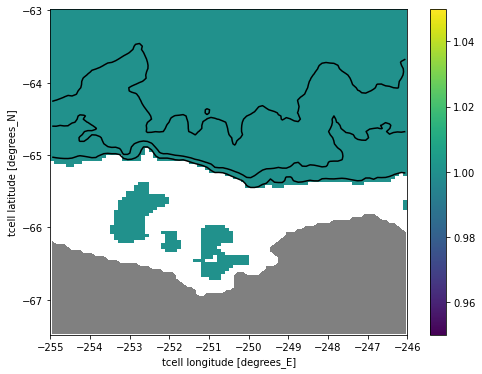

In [24]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_700m.npz')
#contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [25]:
#apply the mask
sigma0 = sigma0*region_mask
sigma0 = sigma0.where(sigma0!=0)

#apply the mask
sigma0_upX = sigma0_upX*region_mask
sigma0_upX = sigma0_upX.where(sigma0_upX!=0)

#apply the mask
sigma0_upY = sigma0_upY*region_mask
sigma0_upY = sigma0_upY.where(sigma0_upY!=0)

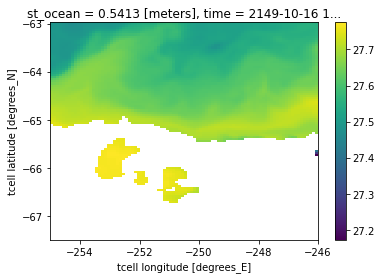

In [26]:
# first time step only:
sigma0[0,0,...].plot()

In [27]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0.where(sigma0>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0*0 + sigma0.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth=min_depth



# mask density where < rho_thresh:
sigma0_off_mask_upX = sigma0_upX.where(sigma0_upX>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array_upX = sigma0_upX*0 + sigma0_upX.st_ocean
# mask depth array using density threshold:
depth_array_masked_upX = depth_array_upX.where(sigma0_upX>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth_upX = depth_array_masked_upX.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth_upX=min_depth_upX


# mask density where < rho_thresh:
sigma0_off_mask_upY = sigma0_upY.where(sigma0_upY>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array_upY = sigma0_upY*0 + sigma0_upY.st_ocean
# mask depth array using density threshold:
depth_array_masked_upY = depth_array_upY.where(sigma0_upY>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth_upY = depth_array_masked_upY.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth_upY=min_depth_upY

In [28]:
isocon = iso2782_dth.mean('time')
iso_upX = iso2782_dth_upX.mean('time')
iso_upY = iso2782_dth_upY.mean('time')

In [29]:
isocon = isocon.load()
isocon_upX = iso_upX.load()
isocon_upY = iso_upY.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


### LOAD EKMAN - needs some testing as it isn't working

In [55]:
## load wind
windX_upY = cc.querying.getvar(experiment_eup,'tau_x',session,frequency='1 monthly',start_time=start_time, end_time=end_time) 
windX_upY = windX_upY.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                
windX_upY = windX_upY.load()

windY_upY = cc.querying.getvar(experiment_eup,'tau_y',session,frequency='1 monthly',start_time=start_time, end_time=end_time) 
windY_upY = windY_upY.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                    
windY_upY = windY_upY.load()

windX_upX = cc.querying.getvar(easterlies_up_zonal,'tau_x', session,frequency='1 monthly',start_time=start_time, end_time=end_time) 
windX_upX = windX_upX.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                     
windX_upX = windX_upX.load()

windY_upX = cc.querying.getvar(easterlies_up_zonal,'tau_y', session,frequency='1 monthly',start_time=start_time, end_time=end_time) 
windY_upX = windY_upY.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)            
windY_upX = windY_upY.load()

In [56]:
windX_con = cc.querying.getvar(control,'tau_x', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
windX_con = windX_con.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                   
windX_con = windX_con.load()

windY_con = cc.querying.getvar(control,'tau_y', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
windY_con = windY_con.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)                   
windY_con = windY_con.load()

In [61]:
## values for Ekman calculation

# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(control,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [62]:
# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

#### calculated for WIND+zonal

In [68]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = windY_upX/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = windX_upX/f
taux_f_con = taux_f_con.fillna(0)

In [69]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_eup = curl_tauf_con/rho0*s_day

#### calculated for WIND+zonal

In [70]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = windY_upY/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = windX_upY/f
taux_f_con = taux_f_con.fillna(0)

In [71]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_zonal = curl_tauf_con/rho0*s_day

#### calculated for control

In [72]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = windY_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = windX_con/f
taux_f_con = taux_f_con.fillna(0)

In [73]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_control = curl_tauf_con/rho0*s_day

### Climatology 

In [92]:
# calculate monthly climatology
clim_eup = ekman_eup.groupby('time.month').mean('time')
clim_eup = ekman_eup.groupby('time.month').mean('time')

clim_zon = ekman_zonal.groupby('time.month').mean('time')
clim_zon = ekman_zonal.groupby('time.month').mean('time')

clim_con = ekman_control.groupby('time.month').mean('time')
clim_con = ekman_control.groupby('time.month').mean('time')

# remove seasonal signal
ekman_eup_s = (ekman_eup - clim_eup)
ekman_zonal_s = (ekman_zonal - clim_zon)
ekman_control_s = (ekman_control - clim_con)

In [95]:
## this helps to check which months are contained on our main data files. 
month=ekman_control_s['time.month'].values


#### Here's a step-by-step explanation of what's happening in the code:

#### ekman_con has the dimensions (time=732, y=100, x=100).
#### climatology is calculated by taking the mean of ekman_con along the time dimension for each month. This results in climatology having dimensions (month=12, y=100, x=100).
#### climatology is then broadcasted to match the shape of ekman_con along the time dimension, so that it now has dimensions (time=732, month=12, y=100, x=100).
#### The broadcasted climatology is then subtracted from ekman_con, resulting in ekman_con_seasonal_removed having dimensions (time=732, month=12, y=100, x=100). This means that the month dimension is preserved in the result.

#### Because of that, we can probably remove the month dimension to not cause issues later on.

In [97]:
# select a single month and drop the 'month' dimension
ekman_eup_s = ekman_eup_s.isel(month=0).drop('month')
ekman_zonal_s = ekman_zonal_s.isel(month=0).drop('month')
ekman_control_s = ekman_control_s.isel(month=0).drop('month')

In [14]:
# select a single month and drop the 'month' dimension
ekman_control_s = ekman_control_s.isel(month=0).drop('month')

### I didn't notice significant difference from the plot, so I will test if the values were different at all:

In [100]:
# calculate absolute difference between ekman_con and ekman_con_seasonal_removed
diff = np.abs(ekman_control - ekman_control_s)

# check if the absolute difference is zero or not
if np.all(diff == 0):
    print("ekman_con and ekman_con_seasonal_removed are identical")
else:
    print("ekman_con and ekman_con_seasonal_removed are different")

ekman_con and ekman_con_seasonal_removed are different


### Apparently they are, so my procedure should have worked. I will try detrending and rolling a 12 month mean through the new data

### First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [101]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [109]:
# I will not detrend this data, only rolling mean to begin with
#ekman_eup_sd = detrend_dim(ekman_eup_s,'time')
#ekman_zonal_sd = detrend_dim(ekman_zonal_s,'time')
#ekman_control_sd = detrend_dim(ekman_control_s,'time')

ekman_eup_sr = ekman_eup_s.rolling(time=12, center=True).mean()
ekman_zonal_sr = ekman_zonal_s.rolling(time=12, center=True).mean()
ekman_control_sr = ekman_control_s.rolling(time=12, center=True).mean()

#### creating the time means

In [110]:
ekman_eup_avg = ekman_eup_sr.mean('time')
ekman_eup_avg = ekman_eup_avg.load()

ekman_zonal_avg = ekman_zonal_sr.mean('time')
ekman_zonal_avg = ekman_zonal_avg.load()

ekman_control_avg = ekman_control_sr.mean('time')
ekman_control_avg = ekman_control_avg.load()

### LOAD BATHYMETRY

In [84]:
#have to load this again
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -246)

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

### PLOT COMPOSITES TOGETHER -> Temperature 

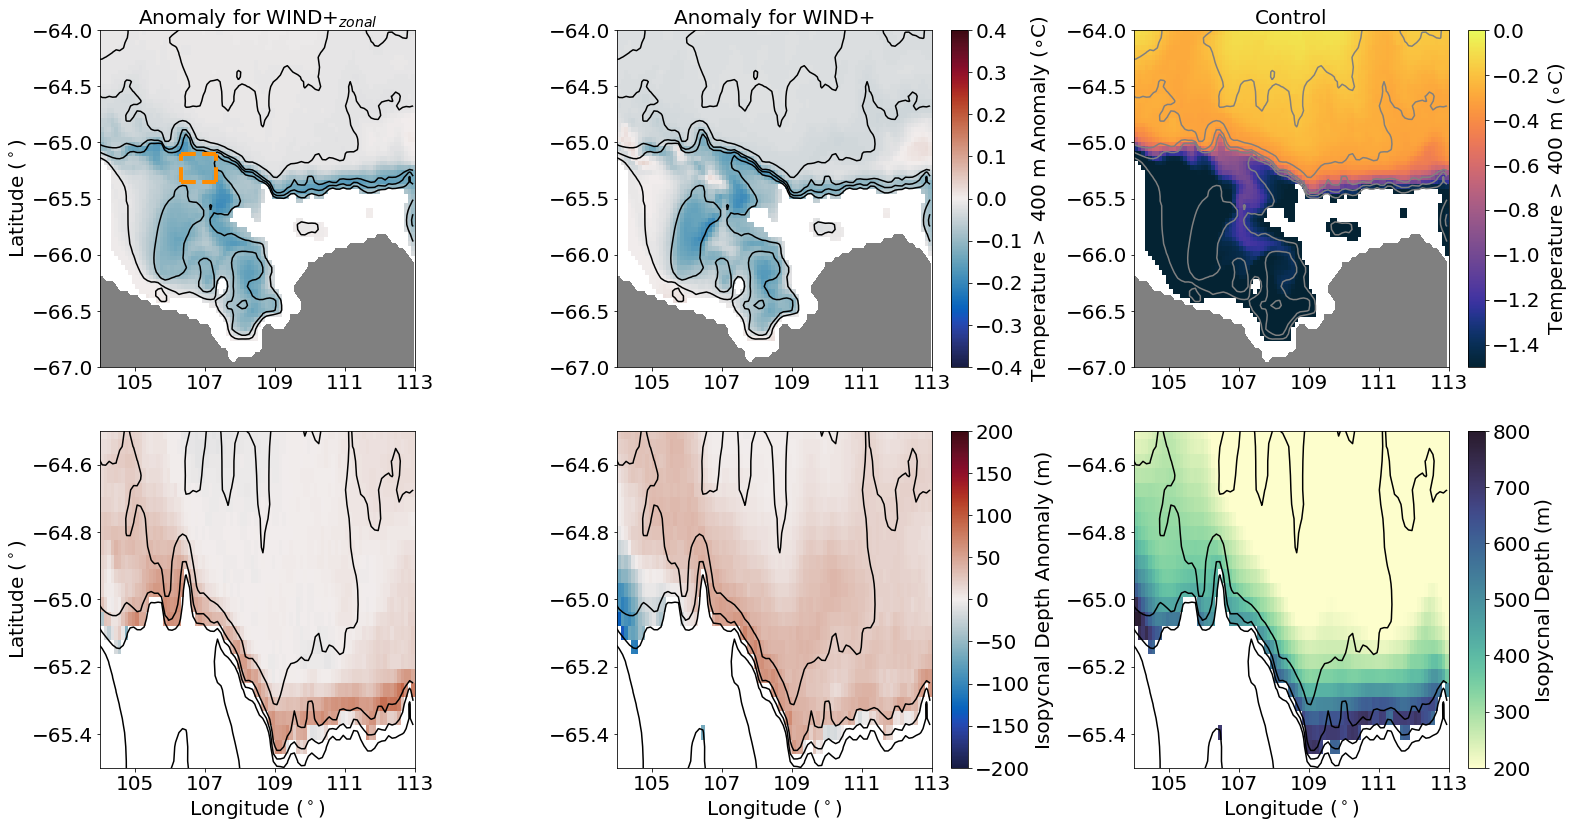

In [85]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = temp_upX-temp_con;
t_low = temp_upY-temp_con;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-0.4,vmax=0.4)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for WIND+$_{zonal}$',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=4)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp Intrusion Box',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-0.4,vmax=0.4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for WIND+$_{merid}$',fontsize=fontsize)
plt.title('Anomaly for WIND+',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature > 400 m Anomaly ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(temp_con.xt_ocean,temp_con.yt_ocean,
                        temp_con, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.title('Control',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature > 400 m ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


t_high = isocon_upX-isocon;
t_low = isocon_upY-isocon;
ax0=plt.subplot(434) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[6])
#cbar.set_label(r'Depth (m)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)

ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,5)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for Lowering T yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Isopycnal Depth Anomaly (m)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,6)    
pc = plt.pcolormesh(isocon.xt_ocean,isocon.yt_ocean,
                        isocon, cmap = cmocean.deep, 
                        vmin=200,vmax=800)
#plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)

cbar.set_label(r'Isopycnal Depth (m)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/fig8b_easterlies_composite_wind+.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### PLOT COMPOSITES TOGETHER -> Ekman

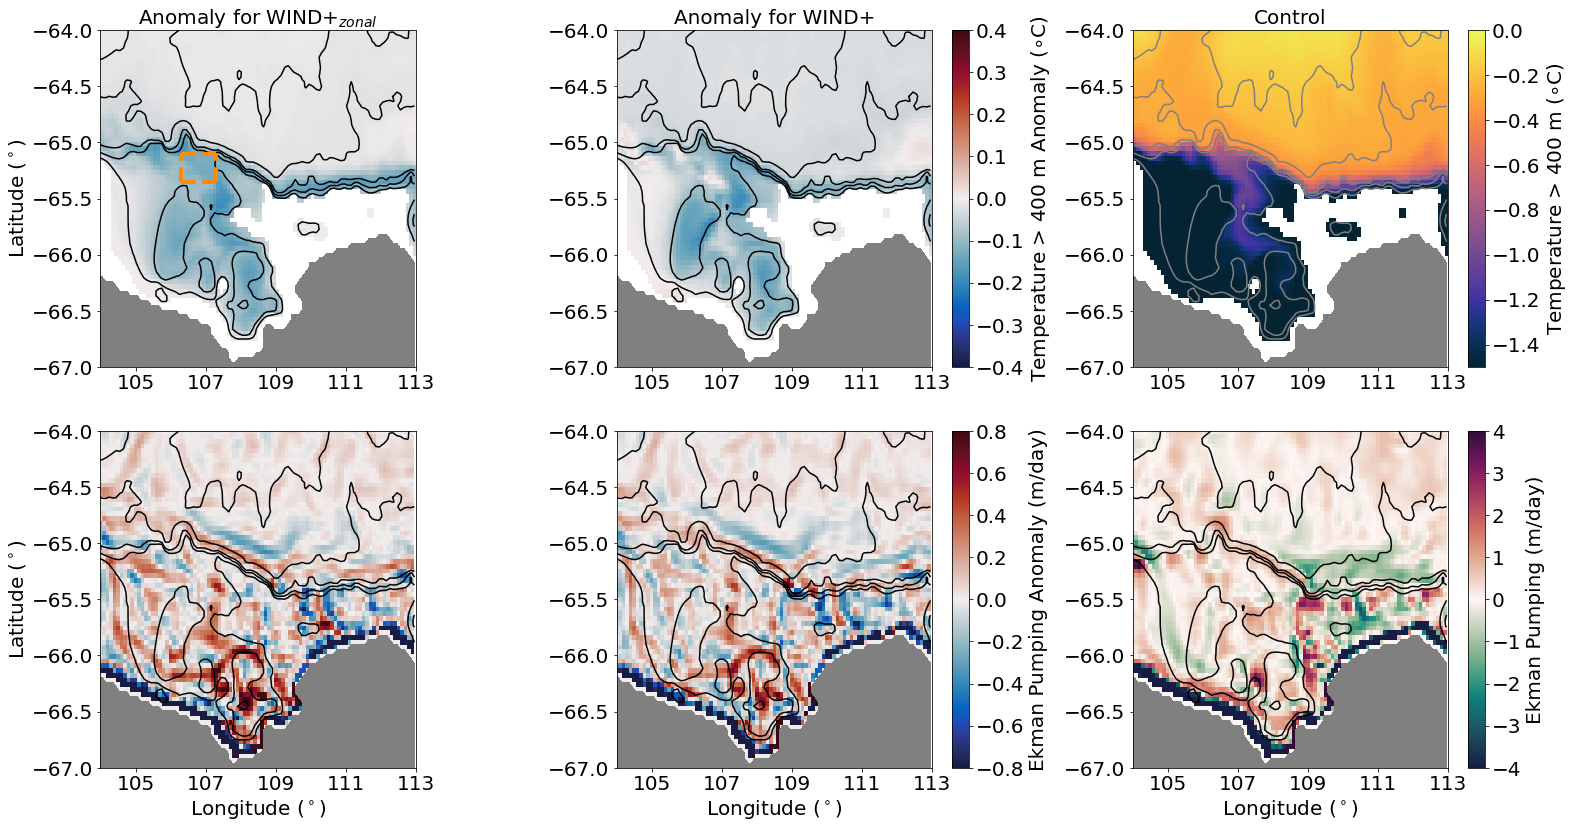

In [112]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = temp_upX-temp_con;
t_low = temp_upY-temp_con;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-0.4,vmax=0.4)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for WIND+$_{zonal}$',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=4)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-0.4,vmax=0.4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for WIND+$_{merid}$',fontsize=fontsize)
plt.title('Anomaly for WIND+',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature > 400 m Anomaly ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(temp_con.xt_ocean,temp_con.yt_ocean,
                        temp_con, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.title('Control',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature > 400 m ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


t_high = ekman_zonal_avg-ekman_control_avg;
t_low = ekman_eup_avg-ekman_control_avg;
ax0=plt.subplot(434) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,1000],colors='darkorange',linewidth=1)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[6])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,5)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='magenta',linestyle='--',linewidth=4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000],colors='magenta',linewidth=2.5)
#plt.plot([-250,-247],[-65,-65],'--')
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman Pumping Anomaly (m/day)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,6)    
pc = plt.pcolormesh(ekman_control_avg.xu_ocean,ekman_control_avg.yu_ocean,
                        ekman_control_avg, cmap = cmocean.curl, 
                        vmin=-4,vmax=4)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman Pumping (m/day)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/fig8b_easterlies_composite_wind+_ekman.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')